In [1]:
import os.path as osp
import numpy as np
import numpy.linalg as npla
import scipy.spatial.transform as sptf
np.set_printoptions(6, suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'font.size': 7,
})

import utils


def load_pred_poses(filename):
    data = np.loadtxt(filename)
    poses = []
    for v in data:
        T_ms = np.eye(4)
        T_ms[:3, :] = v.reshape(3, 4)
        poses.append(T_ms)

    return np.array(poses)


def load_gt_poses(filename):
    data = np.loadtxt(filename, delimiter=' ')

    poses = []
    for tq in data[:, 1:]:
        T_mr = np.eye(4)
        T_mr[:3, :3] = sptf.Rotation.from_quat(tq[3:]).as_matrix()
        T_mr[:3, 3] = tq[:3]
        poses.append(T_mr)
    return np.array(poses)


def plot_pred_poses(ax, pred_poses, gt_poses, label, color):
    T_gt_pred = gt_poses[0] @ npla.inv(pred_poses[0])
    pred_poses = T_gt_pred @ pred_poses
    ax.plot(pred_poses[:, 0, 3], pred_poses[:, 1, 3], label=label, linewidth=1.0, color=color)


gt_path = '/media/yuchen/T7/ASRL/data/dicp'
pred_path = '/ext0/ASRL/steam_icp/results/dicp/'

In [2]:
### compute trajectory distance
sequences = [
    'bunker-road',
    'bunker-road-vehicles',
    'robin-williams-tunnel',
    'brisbane-lagoon-freeway',
]

for sequence in sequences:
  print(f"{sequence}:")
  gt_poses = load_gt_poses(osp.join(gt_path, sequence, 'ref_poses.txt'))
  distance = utils.trajectory_distances(gt_poses)[-1]
  print(f"  distance: {distance}")

bunker-road:
  distance: 865.2771420499731
bunker-road-vehicles:
  distance: 894.2118417752133
robin-williams-tunnel:
  distance: 688.9543594186744
brisbane-lagoon-freeway:
  distance: 4947.117582379512


In [6]:
### compute kitti metric
sequences = [
    'bunker-road',
    'bunker-road-vehicles',
    'robin-williams-tunnel',
    'brisbane-lagoon-freeway',
]
methods = ["doppler_icp", "elastic_icp", "steam_icp", "steam_dicp_cauchy_tls"]
load_gt_fn = lambda sequence: load_gt_poses(osp.join(gt_path, sequence, 'ref_poses.txt'))[60:]
load_pred_fn = lambda sequence, pred_file: load_pred_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
utils.print_results(sequences, methods, load_gt_fn, load_pred_fn)


doppler_icp
  bunker-road   bunker-road-vehicles   robin-williams-tunnel   brisbane-lagoon-freeway 
elastic_icp
  bunker-road   bunker-road-vehicles   robin-williams-tunnel   brisbane-lagoon-freeway 
steam_icp
  bunker-road   bunker-road-vehicles   robin-williams-tunnel   brisbane-lagoon-freeway 
steam_dicp_cauchy_tls
  bunker-road   bunker-road-vehicles   robin-williams-tunnel   brisbane-lagoon-freeway 
kitti metric t_err_2d
doppler_icp  & 1.10 & 1.04 & 0.57 & 1.15  & 1.11
elastic_icp  & 1.99 & 11.04 & 9.07 & 1.10  & 2.76
steam_icp  & 1.36 & 11.62 & 22.70 & 1.69  & 3.58
steam_dicp_cauchy_tls  & 1.45 & 0.69 & 0.45 & 1.30  & 1.22

kitti metric t_err_3d
doppler_icp  & 1.66 & 2.60 & 1.03 & 1.72  & 1.80
elastic_icp  & 2.83 & 12.26 & 9.11 & 1.54  & 3.35
steam_icp  & 2.28 & 12.86 & 22.74 & 2.10  & 4.16
steam_dicp_cauchy_tls  & 2.35 & 2.60 & 0.74 & 1.70  & 1.88

kitti metric r_err_2d
doppler_icp  & 0.0007 & 0.0061 & 0.0028 & 0.0015  & 0.0020
elastic_icp  & 0.0014 & 0.0042 & 0.0019 & 0.0014  

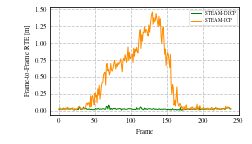

In [4]:
sequences = [
    'bunker-road',
    'bunker-road-vehicles',
    'robin-williams-tunnel',
    'brisbane-lagoon-freeway',
]
sequence = sequences[2]

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
fig.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.95, wspace=0.25, hspace=0.25)

gt_poses = load_gt_poses(osp.join(gt_path, sequence, 'ref_poses.txt'))[60:]

##
pred_file = 'steam_dicp_cauchy_tls'
pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence+'_poses.txt'))[60:]
# rpe metric
t_err, r_err, pose_errors = utils.evaluate_odometry_rpe(gt_poses, pred_poses, 3)
rte = [utils.translation_error(e, 3) for e in pose_errors]
ax.plot(rte, label="STEAM-DICP", linewidth=1.0, color='green')

##
pred_file = 'steam_icp'
pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence+'_poses.txt'))[60:]
# rpe metric
t_err, r_err, pose_errors = utils.evaluate_odometry_rpe(gt_poses, pred_poses, 3)
rte = [utils.translation_error(e, 3) for e in pose_errors]
ax.plot(rte, label="STEAM-ICP", linewidth=1.0, color='darkorange')

ax.set_ylabel('Frame-to-Frame RTE [m]')
ax.set_xlabel('Frame')
ax.grid(which='both', linestyle='--', alpha=0.75)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.legend(framealpha=0.5, fontsize=5)

# plt.savefig('/home/yuchen/ASRL/notes/2023-icra-wu/figs/dicp_result/seq02_local_rte.pdf', format="pdf", bbox_inches="tight")
plt.show()

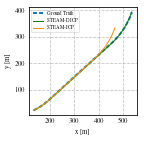

In [5]:
sequences = [
    'bunker-road',
    'bunker-road-vehicles',
    'robin-williams-tunnel',
    'brisbane-lagoon-freeway',
]
sequence = sequences[2]

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
fig.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.95, wspace=0.25, hspace=0.25)

gt_poses = load_gt_poses(osp.join(gt_path, sequence, 'ref_poses.txt'))[60:]
ax.plot(gt_poses[:, 0, 3], gt_poses[:, 1, 3], "--", label='Ground Truth', linewidth=2.0, dashes=(2, 1))

pred_file = 'steam_dicp_cauchy_tls'
pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
plot_pred_poses(ax, pred_poses, gt_poses, 'STEAM-DICP', 'green')

pred_file = 'steam_icp'
pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
plot_pred_poses(ax, pred_poses, gt_poses, 'STEAM-ICP', 'darkorange')

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.grid(which='both', linestyle='--', alpha=0.75)
ax.legend(framealpha=0.5, fontsize=5)
ax.tick_params(axis=u'both', which=u'both', length=0)

# plt.savefig('/home/yuchen/ASRL/notes/2023-icra-wu/figs/dicp_result/seq02_path.pdf', format="pdf", bbox_inches="tight")
plt.show()